In [2]:
import sagemaker

bucket = sagemaker.Session().default_bucket()
prefix = "sagemaker/DEMO-linear-mnist"

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

'arn:aws:iam::846064239600:role/service-role/AmazonSageMakerServiceCatalogProductsUseRole'

### Data ingestion

%%time
import pickle, gzip, numpy, urllib.request, json

fobj = boto3.client('s3').get_object(
    Bucket='sagemaker-sample-files',
    Key='datasets/image/MNIST/mnist.pkl.gz'
)['Body'].read()

with open('mnist.pkl.gz', 'wb') as f:
    f.write(fobj)

# Load the dataset
with gzip.open("mnist.pkl.gz", "rb") as f:
    train_set, valid_set, test_set = pickle.load(f, encoding="latin1")

### Data inspection

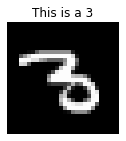

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (2, 10)


def show_digit(img, caption="", subplot=None):
    if subplot == None:
        _, (subplot) = plt.subplots(1, 1)
    imgr = img.reshape((28, 28))
    subplot.axis("off")
    subplot.imshow(imgr, cmap="gray")
    plt.title(caption)


show_digit(train_set[0][30], "This is a {}".format(train_set[1][30]))

### Data conversion

In [7]:
import io
import numpy as np
import sagemaker.amazon.common as smac

vectors = np.array([t.tolist() for t in train_set[0]]).astype("float32")
labels = np.where(np.array([t.tolist() for t in train_set[1]]) == 0, 1, 0).astype("float32")

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, vectors, labels)
buf.seek(0)

0

### Upload training data

In [8]:
import boto3
import os

key = "recordio-pb-data"
boto3.resource("s3").Bucket(bucket).Object(os.path.join(prefix, "train", key)).upload_fileobj(buf)
s3_train_data = "s3://{}/{}/train/{}".format(bucket, prefix, key)
print("uploaded training data location: {}".format(s3_train_data))

uploaded training data location: s3://sagemaker-us-east-1-846064239600/sagemaker/DEMO-linear-mnist/train/recordio-pb-data


In [9]:
output_location = "s3://{}/{}/output".format(bucket, prefix)
print("training artifacts will be uploaded to: {}".format(output_location))

training artifacts will be uploaded to: s3://sagemaker-us-east-1-846064239600/sagemaker/DEMO-linear-mnist/output


### Training the linear model

In [10]:
from sagemaker.image_uris import retrieve

container = retrieve("linear-learner", boto3.Session().region_name)

In [11]:
import boto3

sess = sagemaker.Session()

linear = sagemaker.estimator.Estimator(
    container,
    role,
    train_instance_count=1,
    train_instance_type="ml.c4.xlarge",
    output_path=output_location,
    sagemaker_session=sess,
)
linear.set_hyperparameters(feature_dim=784, predictor_type="binary_classifier", mini_batch_size=200)

linear.fit({"train": s3_train_data})

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


2022-02-24 15:34:58 Starting - Starting the training job...
2022-02-24 15:35:25 Starting - Launching requested ML instancesProfilerReport-1645716898: InProgress
.........
2022-02-24 15:36:46 Starting - Preparing the instances for training.........
2022-02-24 15:38:28 Downloading - Downloading input data...
2022-02-24 15:39:00 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[02/24/2022 15:39:05 INFO 140144085690176] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'ini

### Set up hosting for the model

In [14]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

linear_predictor = linear.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    serializer=CSVSerializer(),
    deserializer=JSONDeserializer()
)

---------!

### Validate the model for use

In [15]:
result = linear_predictor.predict(train_set[0][30:31])
print(result)

{'predictions': [{'score': 3.780501245387313e-08, 'predicted_label': 0}]}


In [16]:
import numpy as np

predictions = []
for array in np.array_split(test_set[0], 100):
    result = linear_predictor.predict(array)
    predictions += [r["predicted_label"] for r in result["predictions"]]

predictions = np.array(predictions)

In [17]:
import pandas as pd

pd.crosstab(
    np.where(test_set[1] == 0, 1, 0), predictions, rownames=["actuals"], colnames=["predictions"]
)

predictions,0,1
actuals,,
0,8973,47
1,37,943


### Delete the Endpoint

In [ ]:
sagemaker.Session().delete_endpoint(linear_predictor.endpoint)